In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import pickle
from zipfile import ZipFile
import xml.sax, xml.sax.handler
import os
from shapely.geometry import Polygon, LineString
import utm
from pyproj import Proj

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm

mpl.rcParams['figure.dpi']= 300
fs = 7
plt.rcParams['text.usetex'] = True #Let TeX do the typsetting
plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)
plt.rcParams['font.family'] = 'sans-serif' # ... for regular text
plt.rcParams['font.sans-serif'] = 'Helvetica' # Choose a nice font here
plt.rcParams['font.size'] = fs
plt.rcParams['figure.facecolor'] = 'white'

<ipython-input-1-90755d315e38>:22: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r'\usepackage{sansmath}', r'\sansmath'] #Force sans-serif math mode (for axes labels)


In [2]:
directory = '/media/andle/Samsung_T5/cmip6/model-ensemble/'

variables = ['uas','vas']
experiments = ['historical','ssp585']
time_bounds = [slice('2005','2014'),
               slice('2091','2100')]
# sources = ['ACCESS-CM2', 'ACCESS-ESM1-5', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR',
#        'CAMS-CSM1-0', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
#        'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3',
#        'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'GFDL-ESM4',
#        'GISS-E2-1-G', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'IITM-ESM',
#        'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KACE-1-0-G',
#        'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR',
#        'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3', 'UKESM1-0-LL'] # sources 0,1,17,18,23,30 have different grids for uas and vas... disregard them for now, need to know how to regrid
sources = ['AWI-CM-1-1-MR', 'BCC-CSM2-MR',
       'CAMS-CSM1-0', 'CMCC-CM2-SR5', 'CNRM-CM6-1', 'CNRM-CM6-1-HR',
       'CNRM-ESM2-1', 'CanESM5', 'CanESM5-CanOE', 'EC-Earth3',
       'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'FGOALS-f3-L', 'GFDL-ESM4',
       'GISS-E2-1-G', 'IITM-ESM',
       'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR',
       'MIROC-ES2L', 'MIROC6', 'MPI-ESM1-2-HR',
       'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NESM3']

In [3]:
# this only needs to be created once
# gcs = gcsfs.GCSFileSystem(token='anon')
# df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
# df.head()

# for j in range(len(sources)):
#     if j==1:
#         df_temp = df.query("table_id == 'Amon' & variable_id == '%s' & source_id == '%s'"%(variables[1],sources[j]))
#     else:
#         df_temp = df.query("table_id == 'Amon' & variable_id == '%s' & source_id == '%s'"%(variables[0],sources[j]))
#     with open(directory+'%s_latlon.pkl'%sources[j], 'wb') as f:
#         pickle.dump((np.asarray(xr.open_zarr(gcs.get_mapper(df_temp.zstore.values[0]), consolidated=True).lat),np.asarray(xr.open_zarr(gcs.get_mapper(df_temp.zstore.values[0]), consolidated=True).lon)),f)
#     for i in range(len(experiments)):
#         df_uas = df.query("table_id == 'Amon' & variable_id == '%s' & experiment_id == '%s' & source_id == '%s'"%(variables[0],experiments[i],sources[j]))
#         df_vas = df.query("table_id == 'Amon' & variable_id == '%s' & experiment_id == '%s' & source_id == '%s'"%(variables[1],experiments[i],sources[j]))
#         if len(df_uas)!=len(df_vas):
#             if sources[j]=='EC-Earth3' and experiments[i]=='historical': # for some reason r24 doesn't exist for vas
#                 print('fixing %s %s'%(sources[j],experiments[i]))
#                 df_uas = df.query("table_id == 'Amon' & variable_id == '%s' & experiment_id == '%s' & source_id == '%s' & member_id != 'r24i1p1f1'"%(variables[0],experiments[i],sources[j]))
#             else:
#                 print('uas not match vas %s %s'%(sources[j],experiments[i]))

#         for l in range(len(df_uas)):
#             if i>0:
#                 m = 1
#             else:
#                 m = 0
#             U = (((xr.open_zarr(gcs.get_mapper(df_uas.zstore.values[l]), consolidated=True).uas.sel(time=time_bounds[m]))**2+
#                   (xr.open_zarr(gcs.get_mapper(df_vas.zstore.values[l]), consolidated=True).vas.sel(time=time_bounds[m]))**2)**0.5).mean('time')
#             with open(directory+'%s_%s_%s_wspd.pkl'%(sources[j],experiments[i],df_uas.member_id.iloc[l]), 'wb') as f:
#                 pickle.dump(np.asarray(U),f)
#             print('%d of %d ensemble members saved'%((l+1),len(df_uas)),end='\r')
#         print('%d of %d sources saved'%((j+1),len(sources)),end='\r')
#     print('%d of %d experiments saved'%((i+1),len(experiments)),end='\r')

In [4]:
class PlacemarkHandler(xml.sax.handler.ContentHandler):
    def __init__(self):
        self.inName = False # handle XML parser events
        self.inPlacemark = False
        self.mapping = {} 
        self.buffer = ""
        self.name_tag = ""
        
    def startElement(self, name, attributes):
        if name == "Placemark": # on start Placemark tag
            self.inPlacemark = True
            self.buffer = "" 
        if self.inPlacemark:
            if name == "name": # on start title tag
                self.inName = True # save name text to follow
            
    def characters(self, data):
        if self.inPlacemark: # on text within tag
            self.buffer += data # save text if in title
            
    def endElement(self, name):
        self.buffer = self.buffer.strip('\n\t')
        
        if name == "Placemark":
            self.inPlacemark = False
            self.name_tag = "" #clear current name
        
        elif name == "name" and self.inPlacemark:
            self.inName = False # on end title tag            
            self.name_tag = self.buffer.strip()
            self.mapping[self.name_tag] = {}
        elif self.inPlacemark:
            if name in self.mapping[self.name_tag]:
                self.mapping[self.name_tag][name] += self.buffer
            else:
                self.mapping[self.name_tag][name] = self.buffer
        self.buffer = ""
        
def build_table(mapping):
    sep = ','
        
    output = 'Name' + sep + 'Coordinates\n'
    points = ''
    lines = ''
    shapes = ''
    for key in mapping:
        coord_str = mapping[key]['coordinates'] + sep
        
        if 'LookAt' in mapping[key]: #points
            points += key + sep + coord_str + "\n"
        elif 'LineString' in mapping[key]: #lines
            lines += key + sep + coord_str + "\n"
        else: #shapes
            shapes += key + sep + coord_str + "\n"
    output += points + lines + shapes
    return output

In [5]:
# parse the kmz
kmz = ZipFile('dunefields.kmz', 'r')
kml = kmz.open('doc.kml', 'r')
parser = xml.sax.make_parser()
handler = PlacemarkHandler()
parser.setContentHandler(handler)
parser.parse(kml)
kmz.close()

# loop through dune fields
for i in np.arange(0,np.shape(list(handler.mapping))[0]):
    coords = handler.mapping[list(handler.mapping)[i]]["coordinates"]
    my_list = coords.split(",")

    # restructure string of coordinates into a useful array
    verts = my_list[:-1]
    vertsclean = np.empty([int(np.shape(verts)[0]/2),2])
    for j in np.arange(0,np.shape(verts)[0]):
        # deal with janky save structure of .kmz
        verts[j]=verts[j].replace('0 ','')
        verts[j]=verts[j].replace('0-','-')
        if j%2==0:
            vertsclean[int(j/2),0] = verts[j]
        else:
            vertsclean[int(j/2),1] = verts[j]
    # now have a coordinate array for the points of the boundary of each dune field
    vertups = np.asarray(vertsclean)

    # save each as a pickle
    with open('dunefields/df%d_verts.pkl'%i, 'wb') as f:
        pickle.dump(vertups, f)

In [6]:
Ndunefields = 45 #-1 for loops
dunefields = []
for i in range(Ndunefields):
    with open('dunefields/df%d_verts.pkl'%i, 'rb') as f:
        vertups = pickle.load(f) # lon,lat
    vertups[:,0] += 180
    dunefields.append(Polygon(vertups))

In [7]:
def get_dftileinfo(latM,lonM):
    lonD = np.diff(lonM)[0]/2
    latD = np.diff(latM)[0]/2

    tiles = [[None for _ in range(len(latM))] for _ in range(len(lonM))]

    for i in range(len(lonM)):
        for j in range(len(latM)):
            tiles[i][j] = Polygon([[lonM[i]+lonD,latM[j]+latD],
                                   [lonM[i]-lonD,latM[j]+latD],
                                   [lonM[i]-lonD,latM[j]-latD],
                                   [lonM[i]+lonD,latM[j]-latD]])

    tilefractionth = 0.0

    Dunefield_dfinds = []
    Dunefield_tileinds = []
    Dunefield_tilelonlat = []
    Dunefield_tilefractions = []

    for k in range(Ndunefields):
        dunefield_dfinds = []
        dunefield_tileinds = []
        dunefield_tilelonlat = []
        dunefield_tilefractions = []
        for i in range(len(lonM)):
            for j in range(len(latM)):
                if tiles[i][j].overlaps(dunefields[k]):
                    if tiles[i][j].intersection(dunefields[k]).area/tiles[i][j].area > tilefractionth:
                        dunefield_dfinds.append(k)
                        dunefield_tileinds.append([i,j])
                        dunefield_tilelonlat.append([lonM[i],latM[j]])
                        dunefield_tilefractions.append(tiles[i][j].intersection(dunefields[k]).area/tiles[i][j].area)
                elif tiles[i][j].within(dunefields[k]):
                    dunefield_dfinds.append(k)
                    dunefield_tileinds.append([i,j])
                    dunefield_tilelonlat.append([lonM[i],latM[j]])
                    dunefield_tilefractions.append(1)
                elif dunefields[k].within(tiles[i][j]):
                    dunefield_dfinds.append(k)
                    dunefield_tileinds.append([i,j])
                    dunefield_tilelonlat.append([lonM[i],latM[j]])
                    dunefield_tilefractions.append(1)
                
        dunefield_tilefractions = np.asarray(dunefield_tilefractions)
        Dunefield_dfinds.append(dunefield_dfinds)
        Dunefield_tileinds.append(dunefield_tileinds)
        Dunefield_tilelonlat.append(dunefield_tilelonlat)
        Dunefield_tilefractions.append(dunefield_tilefractions)
        
    return np.hstack(Dunefield_dfinds),np.vstack(Dunefield_tileinds),np.vstack(Dunefield_tilelonlat),np.hstack(Dunefield_tilefractions)

In [8]:
# for j in range(len(sources)):
#     with open(directory+'%s_latlon.pkl'%sources[j], 'rb') as f:
#         latM,lonM = pickle.load(f)
#     with open(directory+'%s_firstdim-info.pkl'%sources[j], 'wb') as f:
#         pickle.dump(get_dftileinfo(latM,lonM),f)

In [9]:
def get_dfinfo(dfno):
    with open('dunefields/df%d_verts.pkl'%dfno, 'rb') as f:
        vertups = pickle.load(f) # lon,lat

    utmzone = np.empty(np.shape(vertups)[0])
    for k in np.arange(0,np.shape(vertups)[0]):
        utmzone[k] = utm.from_latlon(vertups[k][1],vertups[k][0])[2]

    lonlat2xy = Proj(proj='utm',zone=int(np.median(utmzone)),ellps='WGS84')
    x, y = lonlat2xy(vertups[:,0], vertups[:,1])
    XY = np.asarray([x,y])
    vertups[:,0] += 180
    
    return Polygon(vertups),Polygon(XY.T).area,Polygon(vertups).centroid.coords.xy[1][0],Polygon(vertups).centroid.coords.xy[0][0]
    
def dfmean(q):
    q_dfmeandims = np.asarray(np.shape(q))
    q_dfmeandims[-1] = Ndunefields
    q_dfmean = np.empty(q_dfmeandims)
    for i in range(Ndunefields):
        q_dfmean[...,i] = np.sum(np.squeeze(q[...,np.argwhere(Dunefield_dfinds==i)])*np.squeeze(Dunefield_tilefractions[np.argwhere(Dunefield_dfinds==i)])[tuple([np.newaxis]*(len(np.asarray(np.shape(q)))-1))],axis=-1)/np.sum(Dunefield_tilefractions[np.argwhere(Dunefield_dfinds==i)])
    return q_dfmean

In [10]:
wsp_ens_mean_models = np.empty((len(experiments),len(sources),Ndunefields))
wsp_ens_std_models  = np.empty((len(experiments),len(sources),Ndunefields))

for i in range(len(experiments)):
    for j in range(len(sources)):
        with open(directory+'%s_firstdim-info.pkl'%sources[j], 'rb') as f:
            Dunefield_dfinds,Dunefield_tileinds,Dunefield_tilelonlat,Dunefield_tilefractions = pickle.load(f)
        dirs = []
        for file in os.listdir(directory):
            if file.startswith(sources[j]+'_'+experiments[i]):
                dirs.append(file)
        temp = np.empty((len(dirs),Ndunefields))
        for k in range(len(dirs)):
            with open(directory + dirs[k], 'rb') as f:
                U = pickle.load(f) 
            if len(U)==0:
                temp[k] = np.ones(Ndunefields)*np.nan
            else:
                U = U[Dunefield_tileinds[:,1],Dunefield_tileinds[:,0]]
                
                temp[k] = dfmean(U)
        wsp_ens_mean_models[i,j] = np.mean(temp,axis=0)
        wsp_ens_std_models[i,j]  = np.std(temp,axis=0)

In [11]:
dfs = [None for i in range(Ndunefields)]
df_avlat = np.empty(Ndunefields)
df_avlon = np.empty(Ndunefields)
df_area  = np.empty(Ndunefields)
for i in range(Ndunefields):
    dfs[i],df_area[i],df_avlat[i],df_avlon[i] = get_dfinfo(i)
    
df_name = ['Namib Sand Sea',
           'Grand Erg Occidental',
           'Grand Erg Oriental',
           'West Erg Issaouane',
           'East Erg Issaouane',
           'Idehan Ubari',
           'Idehan Murzuk',
           'Central Great Sand Sea',
           'Dakhla Farafra',
           'Sinai Negev Erg',
           'An Nafud \& Ad Dahna',
           'Rub Al Khali',
           'Ramlat Al Sabatayn',
           'Wahiba Sands',
           'West Registan Desert',
           'Kharan Desert',
           'Karakum Desert',
           'Thar Desert',
           'Rig-e Jenn',
           'Rig-e Yalan',
           'East Registan Desert',
           'Southwest Takla Makan',
           'Northwest Takla Makan',
           'Central Takla Makan',
           'East Takla Makan',
           'Kumtag Desert',
           'Badain Jaran Desert',
           'Tengger Desert',
           'Ulan Buh Desert',
           'Hobp Desert',
           'Munga-Thirri',
           'Yamma Yamma',
           'Gran Desierto',
           'Ergs Iguidi \& Chech',
           'Aoukar',
           'El Djouf',
           'Azefal, Akchar \& Agneitir',
           'Trarza Reion Desert',
           'Skeleton Coast Dune Field',
           'Cunene Namib Desert',
           'Baia dos Tigres Namib Desert',
           'White Sands Dune Field',
           'Algodones',
           'Fachi Bilma',
           'Zaltan Sand Sea']

# Extended Data Figure G

In [12]:
ec_earth3ind = sources.index('EC-Earth3')
temp = 100*(wsp_ens_mean_models[1]-wsp_ens_mean_models[0])/wsp_ens_mean_models[0]
propsignagree = np.empty(Ndunefields)
for i in range(Ndunefields):
    propsignagree[i] = np.sum(np.sign(temp[np.arange(len(sources))!=ec_earth3ind,i])==np.sign(temp[ec_earth3ind,i]))/(len(sources)-1)

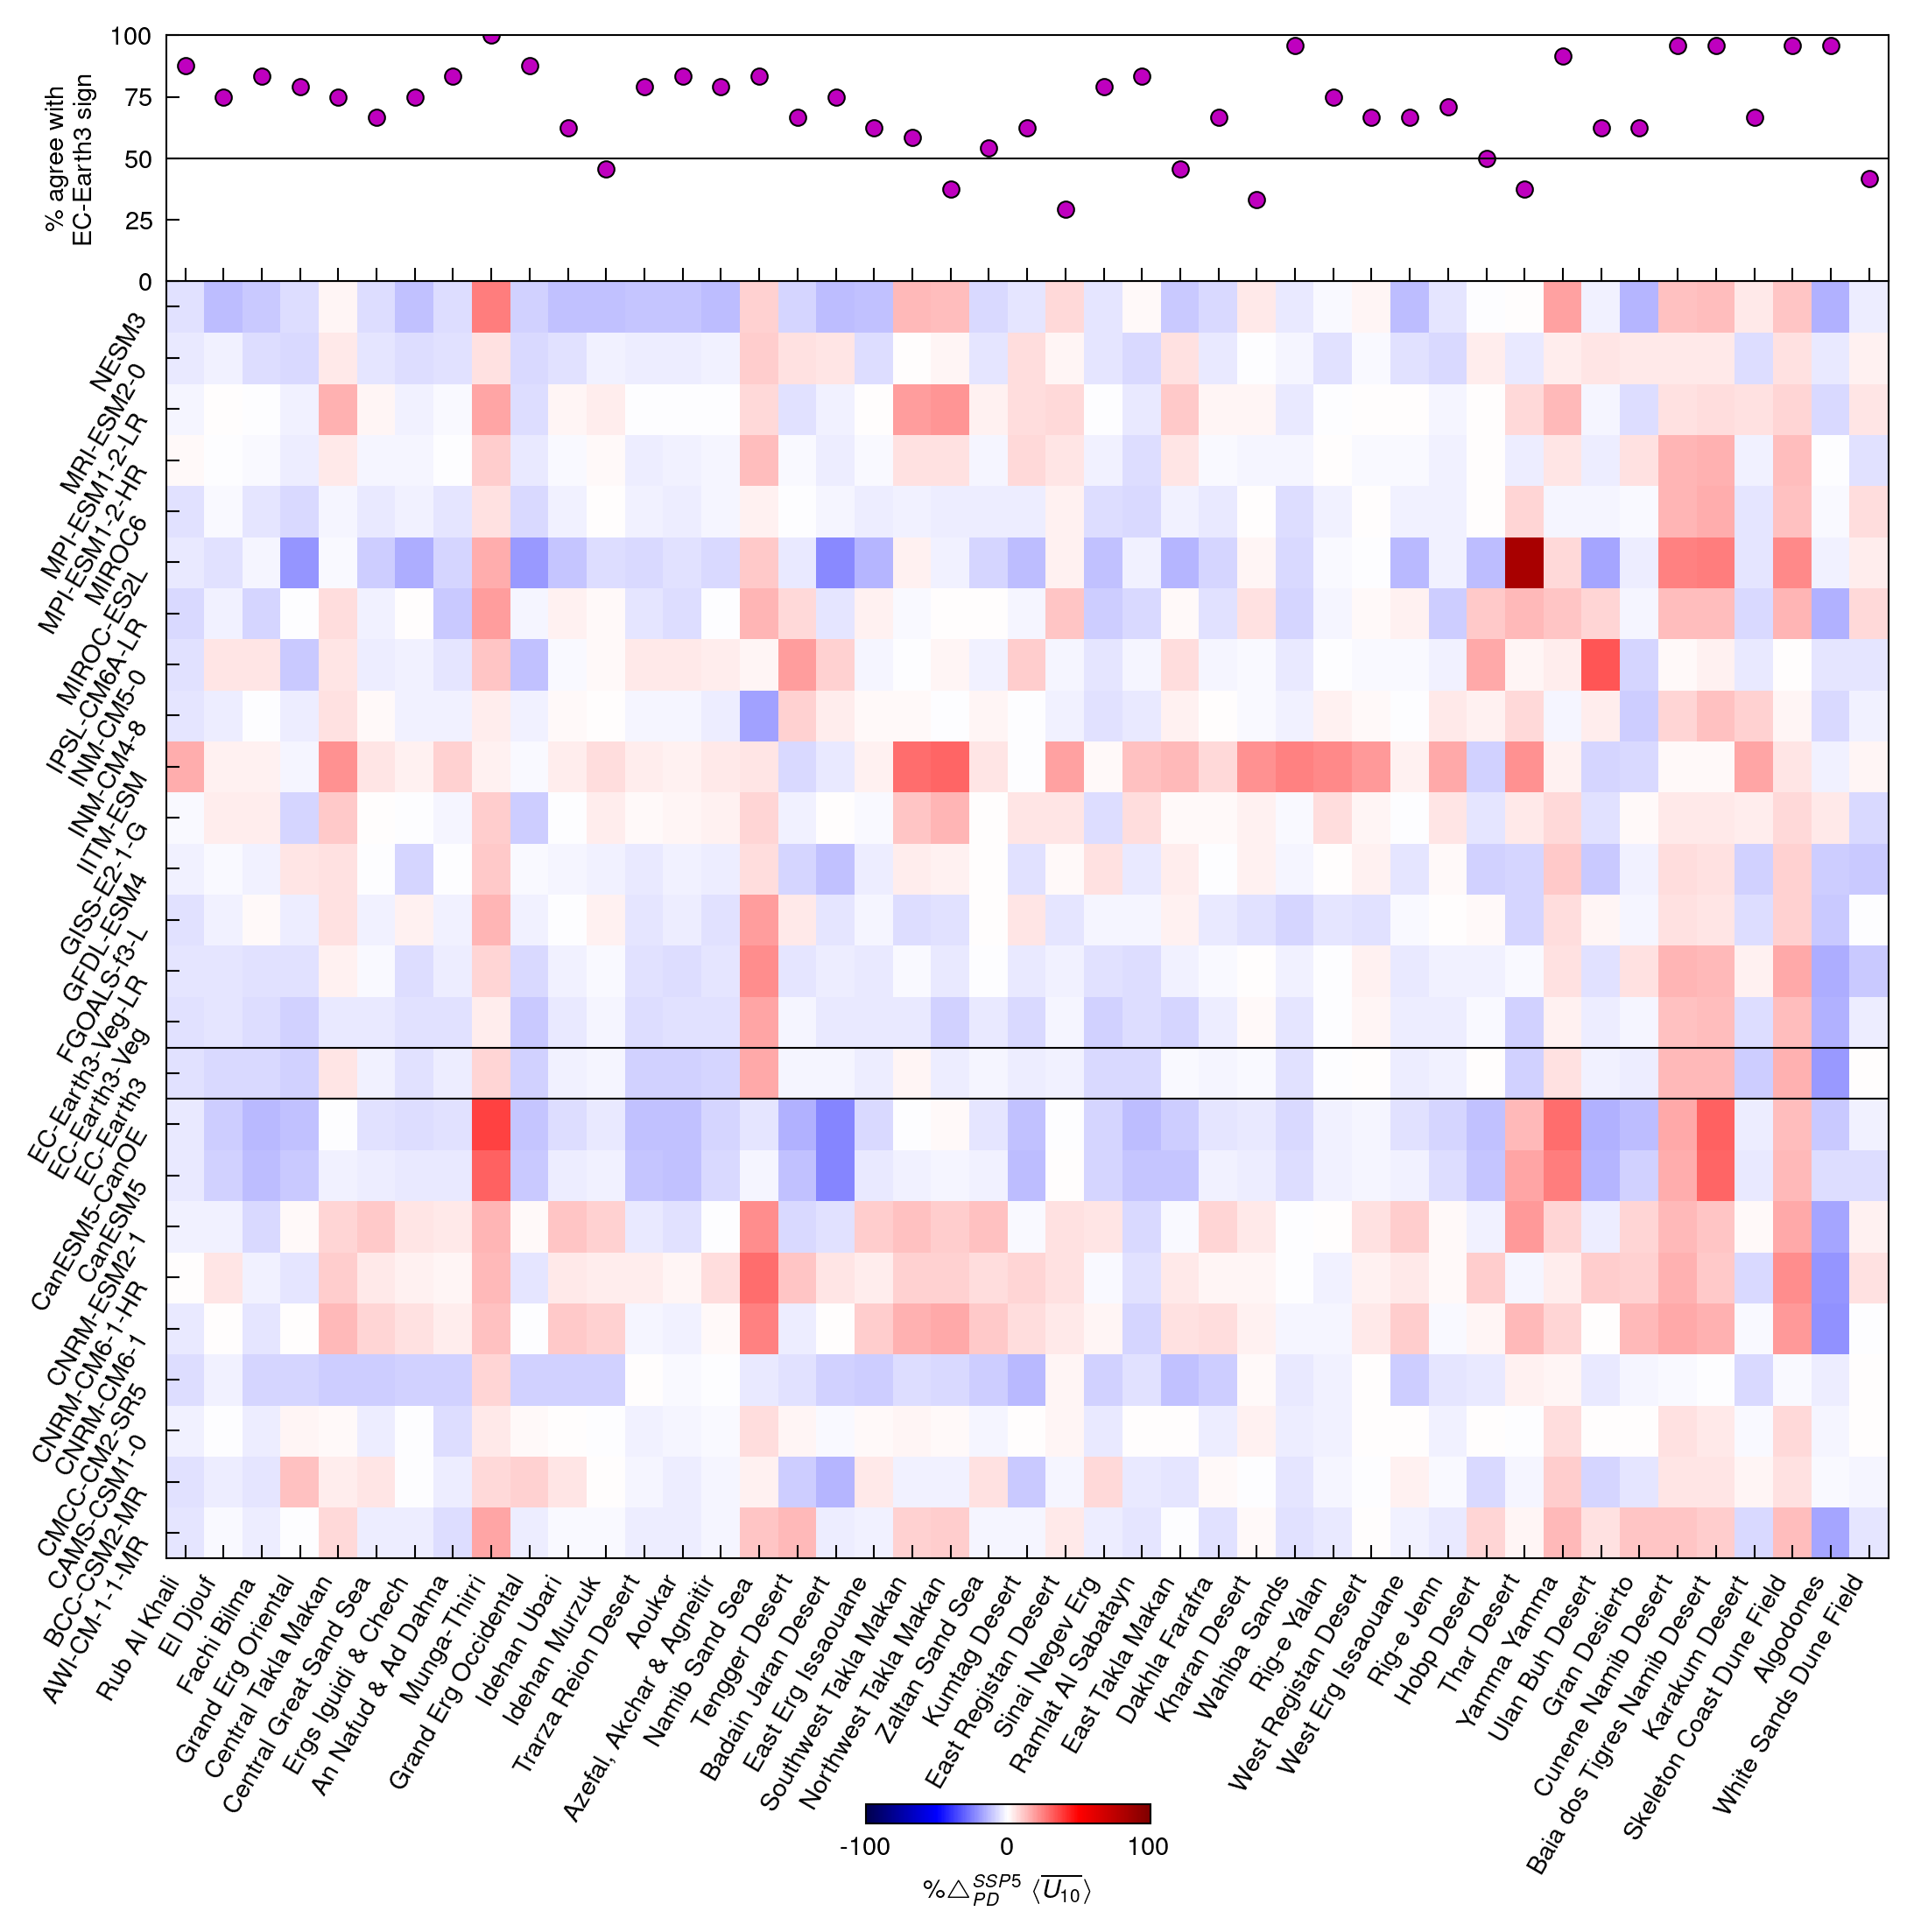

In [13]:
lw = 0.5
S = 20
fig = plt.gcf()

ax0 = fig.add_axes([0.08,0.185,0.91,0.675])

pc0 = plt.pcolor(temp[:,np.argsort(df_area)[::-1]],vmin=-100,vmax=100,cmap='seismic',rasterized=True)

plt.plot([0,len(dfs)],[ec_earth3ind,ec_earth3ind],'k',lw=lw)
plt.plot([0,len(dfs)],[ec_earth3ind+1,ec_earth3ind+1],'k',lw=lw)

plt.xlim(0,len(dfs))
ax0.set_xticks(np.arange(len(dfs))+0.5)
ax0.set_xticklabels([df_name[idx] for idx in np.argsort(df_area)[::-1]],rotation=60,ha='right')

plt.ylim(0,len(sources))
ax0.set_yticks(np.arange(len(sources))+0.5)
ax0.set_yticklabels([sources[idx] for idx in range(len(sources))],rotation=60,va='top')

ax1 = fig.add_axes([0.08,0.86,0.91,0.13])
plt.scatter(np.arange(Ndunefields)+0.5,100*propsignagree[np.argsort(df_area)[::-1]],s=S,edgecolor='k',facecolor='m',lw=lw)
plt.plot([0,Ndunefields],[50,50],color='k',lw=lw)
plt.xlim(0,len(dfs))
plt.ylim(0,100)
plt.ylabel('\% agree with\n EC-Earth3 sign')
ax1.set_xticks(np.arange(len(dfs))+0.5)
ax1.set_xticklabels(['' for idx in np.argsort(df_area)[::-1]])
ax1.set_yticks([0,25,50,75,100])

cbar0_ax = fig.add_axes([0.45,0.045,0.15,0.01])
c0 = fig.colorbar(pc0, orientation='horizontal',cax=cbar0_ax, ticks=[-100,0,100])
cbar0_ax.xaxis.set_label_position('bottom')
cbar0_ax.xaxis.set_ticks_position('bottom')
c0.ax.set_xlabel('\%$\\triangle_{PD}^{SSP5}$  $\\langle\\overline{U_{10}}\\rangle$')
c0.ax.set_xticklabels(['-100','0','100'])
c0.ax.tick_params(width=0,which='both',direction='in')
c0.outline.set_linewidth(lw)

ax0.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax0.spines[axis].set_linewidth(lw) 
ax1.tick_params(width=lw,which='both',direction='in')
for axis in ['top','bottom','left','right']:
    ax1.spines[axis].set_linewidth(lw) 
    
fig.set_size_inches(183/25.4,183/25.4, forward=True)
plt.savefig('figures/edfigG.pdf',dpi=600)
plt.savefig('figures/edfigG.png',dpi=600)